In [ ]:
from fastai.vision.all import *
import pdb

In [ ]:
#hide
#all_slow

# LSH exploration

LSH is an algorithm for clustering of high dimensional data. There are several ways of implementing the algorithm. We'll look at random projections and random rotations.

## LSH clustering

### Random projections

[Yannick](https://www.youtube.com/watch?v=i4H0kjxrias&t=1s) explains LSH with random projections, and the same with this [blog post](https://www.pragmatic.ml/reformer-deep-dive/). That means that in a 2D case we can envision lines drawn at random, and points grouped depending on if they point in a similar direction or not. This method is probabilistic as points that are close can end up in different buckets by chance, but they will have a high probability of beeing grouped to gether. Illustration from the blog:

![Random_projections.png](images/Random_projections.png)

We'll demonstrate random projections for the 2 dimensional case. First we fix some points in the 2d plane. We'll do everything deterministically to begin with:

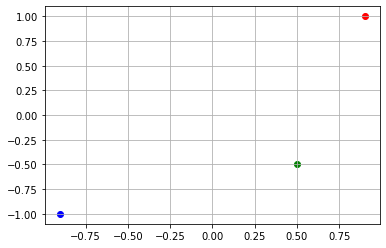

In [ ]:
points = np.array([[0.9, 1],
                   [-0.9, -1],
                   [0.5, -.5]])
fig ,ax = plt.subplots()
for (x, y),c in zip(points, ['r', 'b', 'g']):
        ax.scatter(x, y, c=c)
ax.grid();

Next we make a vector assumed to pass thru the origin. We'll make it a positive unit vector so we can think of it pointing up and to the right. We can manually project this vector from say x = [-1, 1] and display it as a line:

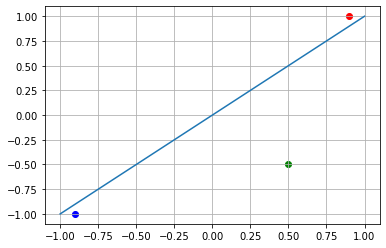

In [ ]:
u = np.array([1, 1])
ax.plot([-1, 1], [-1, 1])
fig

The dot product between vectors a and b is the lenght of a projected onto b multiplied with the length of b. So if two vectors point in the same direction their dot product is positive and vice versa. If vectors are perpendicular the dot product is 0. The doproduct is defined by summing up the pairwise products of two vectors. Note that we can think of our points as vectors from the origin. Taking the dot product of the red point and u, we get as expected a postivite dotproduct:

In [ ]:
(points[0]*u).sum()

1.9

We can calculate the dotproduct for all our points by matrix multiplication. The red vector points along u, the blue opposite, and the green on is perpendicular:

In [ ]:
points@u.T

array([ 1.9, -1.9,  0. ])

We can generalize this in a function by adding randomness, and only keeping the sign of the dotproduct.

In [ ]:
def rand_proj(points):
    u = np.random.randn(1,2) # 1 projection in 2-dim
    dots = points@u.T
    return np.sign(dots)

rand_proj(points)

array([[-1.],
       [ 1.],
       [ 1.]])

> **In this case we have two buckets, -1 and 1**

We can also repeat the bucketing process n times to get a more stable estimate. Each run will produce a different results. Eg. the first column below represents a new hash bucket for the red point.

In [ ]:
[rand_proj(points).squeeze() for _ in range(5)]

[array([ 1., -1.,  1.]),
 array([ 1., -1.,  1.]),
 array([-1.,  1., -1.]),
 array([-1.,  1.,  1.]),
 array([ 1., -1.,  1.])]

We can also generalize this to produce more than two buckets. The number of buckets is 2x the number of random projections:

In [ ]:
def rand_proj(points, n_projections=2, n_dim=2):
    u = np.random.randn(n_projections, n_dim)
    dots = points@u.T
    return np.sign(dots)

rand_proj(points, n_projections=2)

array([[-1.,  1.],
       [ 1., -1.],
       [-1.,  1.]])

In this case we have 4 buckets: [-1,-1], [-1,1], [1,-1], [1,1]. Which could be further combined into a single id [0,1,2,3]

### random rotations

The paper instead opts for an angular interpretation of LSH:

![Random_rotations.png](images/Random_rotations.png)

In the 2d case each point is projected onto a unit sphere, and then rotated randomly. Bucketing will depend on which of the sectors it ends up in. The algorithm is decribed as:  

*To get b hashes, we first fix a random matrix R of size [dk, b/2]. We then define h(x) = arg max([xR; −xR]) where [u; v] denotes the concatenation of two vectors. This method is a known LSH scheme (Andoni et al., 2015) and is easy to implement and apply to batches of vectors.*

The blog has an implementation to compute a single hash wich follows these steps.

In [ ]:
def rand_rotations(x, hidden_dim, n_buckets):
    random_rotations = np.random.randn(hidden_dim, n_buckets // 2)
    rotated_vectors = np.dot(x, random_rotations)
    rotated_vectors = np.hstack([rotated_vectors, -rotated_vectors])
    return np.argmax(rotated_vectors, axis=-1)

In [ ]:
rand_rotations(points, hidden_dim=2, n_buckets=4)

array([3, 1, 2])

This has the nice property of directly giving us the hash-bucket id instead of our list above. The next step will be to scale the algorithm to do several rounds. One could simply loop it, but it will be more effectient to add an extra dimension to our matrices. We will also need to take care of batch and attention head dimensions.

### Incorporation of batches and multiple hashing rounds

In [ ]:
from einops import rearrange, repeat, reduce

The code for the LSH algorithm used for the paper can be found in the [trax library](https://github.com/google/trax/blob/6b4ee9f7473934d15f7b872000be43b1a984bd81/trax/layers/research/efficient_attention.py#L56). Lucidrains also has a stripped down [version](https://github.com/lucidrains/reformer-pytorch/blob/5eb10786dee3fcdb0092a3d8cc415665f0bbdb14/reformer_pytorch/reformer_pytorch.py#L207). We'll base our algorithm on lucidrains, but simplify even further to make the algorithm as clear as possible:
* we'll assume rehashing each round as in trax library
* no dropout on the vectors to be hashed.
* won't pay attention to device at the moment
* assume correct dytpes passed in
* similar number of rotations per head

That means we have to:
1. Keep track of the various dimension
2. perform the random_rotations part of the algorithm (as above)
3. Structure the output depending on number of rounds and buckets

In [ ]:
# From https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py

def hash_vectors(vecs, n_buckets=2, n_rounds=1):

    # 1. account for the input shapes. vecs = [bs, sl, hidden_dim]
    assert n_buckets % 2 == 0
    batch_size, _, hidden_dim = vecs.shape
    rotations_shape = (hidden_dim, n_rounds, n_buckets // 2) 

    # 2. get the dotproduct, cat and argmax like in the section above

    random_rotations = repeat(torch.randn(rotations_shape),  #repeat rotations accross the batch dimension
                              'h nr nb -> bs h nr nb', bs=batch_size)                               
    
    rotated_vecs = torch.einsum('bsh,bhrn->brsn', 
                                vecs,               # [bs, sl, hidden_dim]
                                random_rotations)   # [bs, hidden_dim, n_rounds, n_buckets//2]
                                                    # rotated vecs: [bs, n_rounds, sl, n_buckets//2]
        
    rotated_vecs = torch.cat([rotated_vecs, -rotated_vecs], dim=-1) # [bs, n_rounds, sl, n_buckets]
    buckets = torch.argmax(rotated_vecs, dim=-1)                    # [bs, n_rounds, sl] 

    # 3. Next we add offsets so that bucket numbers from different hashing rounds don't overlap.

    offsets = torch.arange(n_rounds)                               # list of [0,1,2,..n_rounds-1]
    offsets = rearrange(offsets * n_buckets, '(r)-> (1)(r)(1)')    # [1, n_rounds, 1]
    buckets = rearrange(buckets+offsets, 'bs r sl -> bs (r sl)')   # [bs, (n_rounds*sl)]
    return buckets

Let's pass our trusty old points in, but first convert to tensors, and create a batch dimension first.

In [ ]:
t = torch.tensor(points, dtype=torch.float32)
t = rearrange(t, 'b d -> b () d')
hash_vectors(t, n_buckets=2), hash_vectors(t, n_buckets=2, n_rounds=5)

(tensor([[0],
         [1],
         [0]]),
 tensor([[1, 2, 4, 7, 8],
         [0, 3, 5, 6, 9],
         [1, 2, 4, 6, 9]]))

In the multiround case, the result from each hashing round is stacked along the 1 dimension, and an offset is added so each one has a unique index, from [0 to n_rounds * n_hases -1], [0-9] in this case.

In the transformer setting the q and k matrix shapes will be: [bs, sl, hidden_dim]

In [ ]:
t = torch.randn(64, 512, 128)
out = hash_vectors(t, n_buckets=4, n_rounds=1)
out.shape, out.min(), out.max()

(torch.Size([64, 512]), tensor(0), tensor(3))

In [ ]:
out = hash_vectors(t, n_buckets=4, n_rounds=3)
out.shape, out.min(), out.max()

(torch.Size([64, 1536]), tensor(0), tensor(11))

## Main steps of LSH attention

The next parts we need to add are:

![LSH_main-steps.png](images/LSH_main-steps.png)

1. sort first for bucket id, next for position in original sequence
1. chunk buckets to some given size
1. concatenate chunk with previous chunk to allow for inbetween attention
1. calculate attention and output per (concatenated) chunk
1. unsort everything and return

Let's set up some data to test - with a bs of 1 for sake of simplicity

In [ ]:
k = torch.randn(1, 512, 128)
buckets = hash_vectors(k, n_buckets=4, n_rounds=1)
buckets[0,:10]

tensor([1, 1, 1, 2, 1, 3, 2, 1, 3, 0])

The number of vectors in each bucket:

In [ ]:
torch.unique(buckets, return_counts=True)

(tensor([0, 1, 2, 3]), tensor([139, 122, 127, 124]))

We have 512 vectors of dim 128 to sort according to bucket:

In [ ]:
k[0,:,:].shape

torch.Size([512, 128])

### Sorting tensors

In [ ]:
tmp = torch.arange(5*3).reshape((5,3))
tmp

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]])

We can sort along a specified axis, and get the index of the sorted item in the original tensor

In [ ]:
v, i = tmp.sort(dim=1, descending=True)
v

tensor([[ 2,  1,  0],
        [ 5,  4,  3],
        [ 8,  7,  6],
        [11, 10,  9],
        [14, 13, 12]])

In [ ]:
i

tensor([[2, 1, 0],
        [2, 1, 0],
        [2, 1, 0],
        [2, 1, 0],
        [2, 1, 0]])

And use the indices to get our original order back:

In [ ]:
i[:,i[0]]

tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]])

But how do we sort by some other index? We can slice according to the indices of the sorted buckets:

In [ ]:
reorder = [2,0,1]
tmp[:,reorder]

tensor([[ 2,  0,  1],
        [ 5,  3,  4],
        [ 8,  6,  7],
        [11,  9, 10],
        [14, 12, 13]])

Let's get indexes of the sorted buckets tensor and use that to reorder k:

In [ ]:
v, i = buckets.sort(dim=-1)
v[:,:5], v[:,-5:], i[:,:5]

(tensor([[0, 0, 0, 0, 0]]),
 tensor([[3, 3, 3, 3, 3]]),
 tensor([[351, 366, 364, 114, 363]]))

And finally reorder our k. Since we have a batch dimension (0) we have sorted along dim(1) - the rows.

In [ ]:
k[:,i[0],:]

tensor([[[-0.5602, -0.2878, -1.1196,  ..., -1.2602,  1.1406, -0.4469],
         [ 0.5765,  0.1284,  0.0911,  ..., -0.2538, -0.7697, -1.6130],
         [ 0.2006, -0.7220, -1.3837,  ..., -1.2253,  0.5768,  0.6116],
         ...,
         [-0.0983,  0.5041, -1.4759,  ..., -0.6982, -0.0050,  1.1906],
         [-1.5745,  0.4858, -1.5506,  ..., -0.8055, -0.6155, -2.4515],
         [-0.4779, -1.0148,  1.4694,  ..., -1.2689,  0.2453, -0.0928]]])

We can verify that the first item above is the same as the index i[:,0] of our k:

In [ ]:
k[:,i[:,0],:10]

tensor([[[-0.5602, -0.2878, -1.1196, -0.1774, -0.3821, -0.5390, -0.8756,
          -0.2887, -1.0551, -0.4596]]])

We also have to maintain order with respect to the orginial sequence order. So every k in bucket 0 have to be resorted according to it's original place in the sequenze.

### Sort chunks

Chunking to equal size is straight forward. Remove the batch dimension and chunk along the sequence dimension:

In [ ]:
chunks = k.squeeze().chunk(4, dim=0)
k.shape, len(chunks), chunks[0].shape

(torch.Size([1, 512, 128]), 4, torch.Size([128, 128]))

### calculate attention

We can get the attention from a chunk (assuming k=v) the normal way, ignoring attention heads and batch dimension for the moment. We also must make sure that a chunk can attend to the prvious chunk. For chunk 1 this means concatenation with chunk 0, before attention is calculated:

In [ ]:
k0, k1, *_ = chunks
k0.shape, k1.shape

(torch.Size([128, 128]), torch.Size([128, 128]))

In [ ]:
k_01 = torch.cat((k0,k1),0)
k_01.shape

torch.Size([256, 128])

In [ ]:
attn = (k_01@k_01.T).softmax(-1)
attn.shape

torch.Size([256, 256])

In [ ]:
attn[0,:].sum()

tensor(1.)

### caveats

There are some important steps we still need to account for. From the paper:

![paper_1.png](images/paper_1.png)

![paper_2.png](images/paper_2.png)

That means we still have to:
* set h(kj) = h(qj)
* vectors in each chunk have to be sorted according to order in the original sequence
* mask out attention to not attend to it's own position (except when no other targets exist)

## Implement LSH-attention layer

We have a rough idea of the implementation steps, so let's see if we can find a minimal solution based on the implementation by [lucidrains](https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py). Once again will try to strip away as much as possible to leave a minimal solution for clarity:
* no dropout 
* no padding or casusal masking (only masking relevant to LSH)
* don't return attn matrix
* don't account for duplicate attention (unsure about this)
* don't detach tensors where we don't need gradients

### helpers

From: https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py

In [ ]:
# Allow each chunk to attend within itself, and also one chunk back. Chunk
# boundaries might occur in the middle of a sequence of items from the
# same bucket, so this increases the chances of attending to relevant items.
def look_one_back(x):
    x_extra = torch.cat([x[:, -1:, ...], x[:, :-1, ...]], dim=1)
    return torch.cat([x, x_extra], dim=2)

In [ ]:
def sort_key_val(t1, t2, dim=-1):
    values, indices = t1.sort(dim=dim)
    t2 = t2.expand_as(t1)
    return values, t2.gather(dim, indices)

In [ ]:
def batched_index_select(values, indices):
    last_dim = values.shape[-1]
    return values.gather(1, indices[:, :, None].expand(-1, -1, last_dim))

In [ ]:
def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max

In [ ]:
def chunked_sum(tensor, chunks=1):
    *orig_size, last_dim = tensor.shape
    tensor = tensor.reshape(-1, last_dim)
    summed_tensors = [c.sum(dim=-1) for c in tensor.chunk(chunks, dim=0)]
    return torch.cat(summed_tensors, dim=0).reshape(orig_size)

In [ ]:
TOKEN_SELF_ATTN_VALUE = -5e4 # carefully set for half precision to work

### Forward, step by step

Let's step through the forward() of the LSHAttention layer (below), to see if we can makes sense of it. We start with random test data. We assume `q=k`, and pass along `v` as well:

In [ ]:
bs, sl, dim = 64, 512, 256
qk, v = torch.randn((bs, sl, dim)), torch.randn((bs, sl, dim))
qk.shape, v.shape

(torch.Size([64, 512, 256]), torch.Size([64, 512, 256]))

#### hashing

Grouping is done by `hash_vector()`. We'll test 6 rounds with 16 buckets.

In [ ]:
n_buckets, n_rounds = 16, 6
buckets = hash_vectors(qk, n_buckets, n_rounds)
buckets.shape

torch.Size([64, 3072])

In [ ]:
buckets[0,:20]

tensor([ 5,  0,  5, 14,  2,  4,  0,  1,  5,  3, 14,  9, 10,  0,  3,  4,  0, 15,
        12,  6])

Note that our bucket ids are unique within their hash group. I.e. the first and second hash group has non overlaping bucket ids:

In [ ]:
buckets[0, 0:sl].unique(), buckets[0, sl:2*sl].unique()

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 tensor([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))

The ticker is an index into the original sequence id:

In [ ]:
# a vector of [bs, n_hashes*seqlen), where ticker[0,:]= [0,1,2, ..-, seqlen*n_hash-1]
ticker = torch.arange(n_rounds * sl).unsqueeze(0).expand_as(buckets) 
ticker

tensor([[   0,    1,    2,  ..., 3069, 3070, 3071],
        [   0,    1,    2,  ..., 3069, 3070, 3071],
        [   0,    1,    2,  ..., 3069, 3070, 3071],
        ...,
        [   0,    1,    2,  ..., 3069, 3070, 3071],
        [   0,    1,    2,  ..., 3069, 3070, 3071],
        [   0,    1,    2,  ..., 3069, 3070, 3071]])

Note that the id is not reset between hash groups:

In [ ]:
ticker[0, sl-5:sl+5]

tensor([507, 508, 509, 510, 511, 512, 513, 514, 515, 516])

But by taking the mod of sl, we can get the sequence id in each hash round:

In [ ]:
(ticker % sl)[0, sl-5:sl+5]

tensor([507, 508, 509, 510, 511,   0,   1,   2,   3,   4])

Or the id of the hash round by integer division with sl

In [ ]:
(ticker//sl)[0, sl-5:sl+5]

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

#### Sorting

In the lsh layer we make a `buckets_and_t` index. It's the bucket id scaled by sl + `ticker % sl`. Let's inspect the first component:

In [ ]:
buckets[0,:10]

tensor([ 5,  0,  5, 14,  2,  4,  0,  1,  5,  3])

We scale it by muliplying with sl:

In [ ]:
sl*buckets[0,:10]

tensor([2560,    0, 2560, 7168, 1024, 2048,    0,  512, 2560, 1536])

Then we add `ticker%sl` which is the the sequence id (see above)

In [ ]:
# ticker % seqlen = [o...seqlen-1, 0...seqlen-1, ...] n_bucket times
# we add the bucket id scaled by seqlen
# shape: [bs, (seqlen*buckets)]
# let us sort according to bucket id and index in sequence
buckets_and_t = sl * buckets + (ticker % sl)
buckets_and_t

tensor([[ 2560,     1,  2562,  ..., 41469, 48638, 45567],
        [ 7680,  4097,  4098,  ..., 43517, 41982, 47103],
        [ 1024,  4097,  7170,  ..., 45565, 48638, 41983],
        ...,
        [ 4096,  6657,  3586,  ..., 43005, 47102, 44031],
        [ 7168,  4609,   514,  ..., 44029, 44542, 44031],
        [ 1536,  7681,  3586,  ..., 44541, 43518, 42495]])

`Buckets_and_t` is an index that takes both hash group id and sequence id into account, on the form `bucket_id*sl + sequence id`. The first item can take one of 16 values (n_buckets):

In [ ]:
idxs = [idx*sl + 0 for idx in range(n_buckets)]
print(idxs)

[0, 512, 1024, 1536, 2048, 2560, 3072, 3584, 4096, 4608, 5120, 5632, 6144, 6656, 7168, 7680]


For the second position we add 1 to offset for the sequence id:

In [ ]:
print([idx+1 for idx in idxs])

[1, 513, 1025, 1537, 2049, 2561, 3073, 3585, 4097, 4609, 5121, 5633, 6145, 6657, 7169, 7681]


And we can recreate the original ids from `buckets_and_t`:

In [ ]:
(buckets_and_t[0,:20] - ticker[0,:20])/sl

tensor([ 5.,  0.,  5., 14.,  2.,  4.,  0.,  1.,  5.,  3., 14.,  9., 10.,  0.,
         3.,  4.,  0., 15., 12.,  6.])

In [ ]:
buckets[0,:20]

tensor([ 5,  0,  5, 14,  2,  4,  0,  1,  5,  3, 14,  9, 10,  0,  3,  4,  0, 15,
        12,  6])

`Buckets_and_t` is a unique index:

In [ ]:
len(buckets_and_t[0,:]), len(buckets_and_t[0,:].unique())

(3072, 3072)

It's also non overlapping between hash groups - the max id of the first group is smaller than the min id of the second group:

In [ ]:
buckets_and_t[0,:sl].max(), buckets_and_t[0,sl:sl*2].min()

(tensor(8189), tensor(8202))

Next we sort buckets_and_t. Since we scaled the id's, hash groups are autmatically sorted.

In [ ]:
# Hash-based sort ("s" at the start of variable names means "sorted")
sbuckets_and_t, sticker = sort_key_val(buckets_and_t, ticker, dim=-1)     # shapes are [bs, seqlen*n_hashes]
sbuckets_and_t[0,:20]

tensor([  1,   6,  13,  16,  20,  34,  42,  45,  51,  52,  95,  98, 100, 107,
        112, 127, 158, 192, 215, 219])

`sticker` are the ids from our original `buckets_and_t`. That is, when we unsort `sbuckets`, `sticker` gives us the index of where the items belong in `buckets_and_t`.

In [ ]:
sticker[0,sl:sl+10]

tensor([522, 524, 531, 533, 540, 541, 567, 579, 596, 597])

We can use `sticker` to look up items in `buckets_and_t` to create `sbuckets_and_t`, but not the other way around!

In [ ]:
buckets_and_t[0,sticker[0,-10:]], sbuckets_and_t[0,-10:]

(tensor([48964, 48969, 48987, 48999, 49011, 49028, 49034, 49068, 49089, 49107]),
 tensor([48964, 48969, 48987, 48999, 49011, 49028, 49034, 49068, 49089, 49107]))

But we must also be able to undo this sorting. By doing a normal sort on the sticker list, we get a set of ids that tells us where an item belong in the original buckets_and_t:

In [ ]:
_, undo_sort = sticker.sort(dim=-1)                                       # indexes to undo sortings

We can use the gather function to recreate `buckets_and_t` from the sorted buckets. And we already know we can recreate seqlen id and hash group id from `buckets_and_t`

In [ ]:
sbuckets_and_t.gather(-1, undo_sort)

tensor([[ 2560,     1,  2562,  ..., 41469, 48638, 45567],
        [ 7680,  4097,  4098,  ..., 43517, 41982, 47103],
        [ 1024,  4097,  7170,  ..., 45565, 48638, 41983],
        ...,
        [ 4096,  6657,  3586,  ..., 43005, 47102, 44031],
        [ 7168,  4609,   514,  ..., 44029, 44542, 44031],
        [ 1536,  7681,  3586,  ..., 44541, 43518, 42495]])

In [ ]:
(sbuckets_and_t.gather(-1, undo_sort)[0,0:20] - ticker[0,:20])/sl

tensor([ 5.,  0.,  5., 14.,  2.,  4.,  0.,  1.,  5.,  3., 14.,  9., 10.,  0.,
         3.,  4.,  0., 15., 12.,  6.])

In [ ]:
buckets[0,:20]

tensor([ 5,  0,  5, 14,  2,  4,  0,  1,  5,  3, 14,  9, 10,  0,  3,  4,  0, 15,
        12,  6])

**To recap:**
* `sbuckets_and_t` is a "double index" sorted by **both** hash group id and sequence id
* we can use `undo_sort` to recreate `buckets_and_t`, which is an index of hash_group and sequence id in the original order
* we can use `buckets_and_t` to get the original bucket ids in their respective hash groups, i.e. `buckets`

#### Chunking

The next step is to extract the relevant vectors from our input. First we take the `sticker` mod with sl to produce the sequence id for each hash group. This gives us the id of `qk` and `v` to look up:

In [ ]:
st = (sticker % sl)              # index of [0..seqlen-1] for each hash round (n_hashes)[bs, seqlen*n_hashes]
st

tensor([[  1,   6,  13,  ..., 428, 449, 467],
        [ 12,  20,  27,  ..., 483, 491, 506],
        [ 24,  26,  29,  ..., 409, 423, 468],
        ...,
        [  6,  21,  31,  ..., 459, 468, 469],
        [  9,  13,  80,  ..., 433, 457, 500],
        [ 13,  25,  36,  ..., 448, 474, 482]])

We then lookup the vectors according to their (sorted) seqlen id:

In [ ]:
sqk = batched_index_select(qk, st)   # get the sorted qk, [bs, seqlen, model_dim]
sv = batched_index_select(v, st)     # get the sorted v, [bs, seqlen, model_dim] 
sqk.shape, sv.shape

(torch.Size([64, 3072, 256]), torch.Size([64, 3072, 256]))

`sqk` and `sv` now contains the input vectors sorted by hash group and seqlen id. Next we calculate the number of chunks. We assume chunks of even size, regardless of how many vectors are actually in a particular group:

In [ ]:
n_chunks = n_rounds * n_buckets
n_chunks

96

Each chunk has a size along the sl dimension (chunk_size) of:

In [ ]:
sqk.shape[1]/n_chunks, sl/n_buckets

(32.0, 32.0)

Next we reshape both the `st` index, `sqk` and `sv` to add the `n_chunks` dimension.
We operate with one index for the query, and a another (duplicate) for k and v:

In [ ]:
# Split off a "bin" axis so that attention only occurs within chunks.
# get the qk and v chunks and also the indexes to undo sort later
bq_t = bkv_t = torch.reshape(st, (bs, n_chunks, -1))   # [bs, n_chunks, chunk_size]
bq_t.shape

torch.Size([64, 96, 32])

In [ ]:
bqk = torch.reshape(sqk, (bs, n_chunks, -1, dim))      # [bs, n_chunks, chunk_size, model_dim]
bv = torch.reshape(sv, (bs, n_chunks, -1, dim))        # [bs, n_chunks, chunk_size, model_dim]
bqk.shape, bv.shape

(torch.Size([64, 96, 32, 256]), torch.Size([64, 96, 32, 256]))

The next step it to split `k` and `v`. We normalize `k` but **not** `q`. This is mentioned in the paper:

![paper_3.png](images/paper_3.png)

In [ ]:
bq = bqk
bk = F.normalize(bqk, p=2, dim=-1).type_as(bq)
bq[..., :].mean(), bk[...,:].mean()

(tensor(0.0001), tensor(8.9945e-06))

Next we add the previous chunk as described in the paper, but only for `k` and `v`:

In [ ]:
bk = look_one_back(bk)            # [bs, n_chunks, chunk_size*2, model_dim]
bv = look_one_back(bv)            # [bs, n_chunks, chunk_size*2, model_dim]
bkv_t = look_one_back(bkv_t)      # [bs, n_chunks, chunk_size*2, model_dim]

Note that bq and bk now have different shapes:

In [ ]:
bk.shape, bq.shape

(torch.Size([64, 96, 64, 256]), torch.Size([64, 96, 32, 256]))

#### dot product attention

In [ ]:
dots = torch.einsum('bnsd,bnzd->bnsz', 
                            bq,                  # [bs, n_chunks, chunk_size, model_dim]
                            bk                   # [bs, n_chunks, chunk_size*2, model_dim]
                           ) * (dim ** -0.5)     # dots: [bs, n_chunks, chunk_size, chunk_size*2]
dots.shape

torch.Size([64, 96, 32, 64])

![paper_4.png](images/paper_4.png)

In [ ]:
# Mask out attention to self except when no other targets are available.
self_mask = bq_t[:, :, :, None] == bkv_t[:, :, None, :]
self_mask.shape      # [bs, n_chunks, chunk_size, chunk_size*2]

torch.Size([64, 96, 32, 64])

We achieve this by comparing the sorted and chunked buckets index with each other for `k` and `q` respectively. If they are equal we mask them.

In [ ]:
bq_t[:, :, :, None][0,0,:10,0], bkv_t[:, :, None, :][0,0,0,:10]

(tensor([ 1,  6, 13, 16, 20, 34, 42, 45, 51, 52]),
 tensor([ 1,  6, 13, 16, 20, 34, 42, 45, 51, 52]))

In [ ]:
self_mask[0,0,:5,:5]

tensor([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

In [ ]:
self_mask[0,0,...].shape, self_mask[0,0,...].sum()

(torch.Size([32, 64]), tensor(34))

In [ ]:
dots.masked_fill_(self_mask, TOKEN_SELF_ATTN_VALUE)
del self_mask

#### Avoid double counting of query-key pairs

According to the appendix of the paper we need to avoid double counting q/k pairs over multiple rounds of hashing.

![paper_5.png](images/paper_5.png)

The lucidrains [implementation](https://github.com/lucidrains/reformer-pytorch/blob/5eb10786dee3fcdb0092a3d8cc415665f0bbdb14/reformer_pytorch/reformer_pytorch.py#L354) mentions two strategies to deal with this, where only the first one is implemented, and seems to align with the paper:  
*The default is to count how many times a query-key pair is repeated, and to lower its log-prob correspondingly at each repetition*

**Note that this implementation does not fold this term into the mask (like the paper), but calculates it separately.**

> The goal is to consider each attention chunk (i.e. our input sorted by hash bucket id, and sequence id, and split in to n_chunks). For each chunk we have to assess: did a one particular key/query pair end up in similar attention chunks in a later hash round. If so we can argue that the model might "over focus" on this particular q/k pair, and that regularizing it (penalizing) probably makes sense.

First of all, we will be subracting the counts from `dots`, so they should have a similar shape in the end. We also expect the max count to be 6 (`n_rounds`). 

In [ ]:
dots.shape # [bs, n_chunk, chunk_size, chunk_size*2]

torch.Size([64, 96, 32, 64])

Consider item [0,0] in the first attention chunk (in eg. the 0th sample of the batch dimension). It ended up here because of the sorting. I.e. it must have had bucket number 0, and a pretty low sequence id (let's call it `x_id`) to end up as the first item (in this particular round). But in the next hash rounds it will get a different bucket id, and thus a different location in the sorting for that particular round. We have to associate the item from the input sequence,`x_id`, with our item[0,0] from the first hash round, and track where this item (`x_id`) in the original input sequence ended up in later hash rounds.

Also note that it dosen't have to be identical attention chunks, just similar. So if [k32, q34] end up in the attention chunk 44 in the first round, 88 in the second, but 44 and 33 in the third, our count will be 2.

First we need to create an index which tells us at which attention chunk a particular item in the input end up in in each hash round. Note that `undo_sort` is the key to take our sorted vectors back to original order. Eg. `undo_sort[0,0]` tells us where in the original sequence the item that ended up as item 0 after sorting belongs:

In [ ]:
undo_sort[0,:10], undo_sort[0,sl:sl+10]

(tensor([174,   0, 175, 447,  69, 148,   1,  38, 176, 110]),
 tensor([974, 775, 655, 710, 550, 776, 737, 777, 656, 657]))

`undo_sort` tells us the sequence id where the sorted items will move to. Consider item 50 in our sorted sequences. It comes from various spots in the original input sequence in each of the 6 hash rounds, depending on which bucket it happend to fall into:

In [ ]:
[undo_sort[0,s_id + 50].item() for s_id in range(0,sl*6, sl)]

[366, 940, 1368, 1631, 2483, 2635]

If we take the mod of sl, we get the item's location *within* the original sequence at each hash round. And after sorting they end up at index 50.

In [ ]:
[undo_sort[0,s_id + 50].item()%sl for s_id in range(0,sl*6, sl)]

[366, 428, 344, 95, 435, 75]

If we instead take the mod of `chunk_size` (32 in this case), we get an index of which of the 96 chunks (`n_rounds*n_buckets`) the items ends up in. That means that the 50th element in the sorted sequences will end up in the following attention chunks:

In [ ]:
[undo_sort[0,s_id + 50].item()//32 for s_id in range(0,sl*6, sl)]

[11, 29, 42, 50, 77, 82]

We can do this for all items, and thus create a `locs1` id that gives us an item's attention chunk id.

In [ ]:
locs1 = undo_sort // bq_t.shape[-1]  # same as chunk size
locs1.shape, locs1.min(), locs1.max()

(torch.Size([64, 3072]), tensor(0), tensor(95))

Eg. items 0-5 in the sorted sequences end up in various attention chunks depending on which hash round we are in:

In [ ]:
[locs1[0,slen:slen+5] for slen in range(0,sl*n_rounds, sl)]

[tensor([ 5,  0,  5, 13,  2]),
 tensor([30, 24, 20, 22, 17]),
 tensor([44, 42, 32, 36, 40]),
 tensor([49, 55, 50, 59, 53]),
 tensor([72, 74, 77, 78, 68]),
 tensor([85, 92, 88, 83, 94])]

We divided attention in even chunks, so bucket_id and attention chunk id won't always match:

In [ ]:
buckets[0,sl:sl+5], locs1[0,sl:sl+5]

(tensor([30, 24, 20, 22, 17]), tensor([30, 24, 20, 22, 17]))

Next we create an id that is offset by one, except when it overflows our maximum id of 95, by taking the mod. We need this since our `keys` will be twice the size of the `queries`, and come from the neighbouring chunk.

In [ ]:
95%n_chunks, 96%n_chunks, 97%n_chunks

(95, 0, 1)

In [ ]:
locs2 = (locs1 + 1) % n_chunks
locs2.shape

torch.Size([64, 3072])

This means that the combination of locs1 and 2 gives us ids to neighbour chunks.

In [ ]:
locs1[0,-15:], locs2[0,-15:]

(tensor([88, 89, 91, 89, 92, 89, 87, 82, 90, 87, 82, 94, 80, 94, 88]),
 tensor([89, 90, 92, 90, 93, 90, 88, 83, 91, 88, 83, 95, 81, 95, 89]))

Next we reshape `locs1` and `locs2` to [bs, n_rounds, sl], concatenate them along the `n_rounds` dim, and switches the `n_rounds` and `sl` axis.

In [ ]:
# if not self._attend_across_buckets: # we will assume that this is true
#     locs1 = buckets * chunk_size + locs1
#     locs2 = buckets * chunk_size + locs2

locs = torch.cat([
    torch.reshape(locs1, (bs, n_rounds, sl)),
    torch.reshape(locs2, (bs, n_rounds, sl)),
], 1).permute((0, 2, 1))
locs.shape           # [bs, sl, n_rounds*2]

torch.Size([64, 512, 12])

This means that the item that happende to be first in the sorted sequences ends up in various chunks depending on which hash bucket it ends up in in each round since this will affect it's sorting. The last half of the list is the neighbour chunks to our item:

In [ ]:
locs[0, 0,:]

tensor([ 5, 30, 44, 49, 72, 85,  6, 31, 45, 50, 73, 86])

This is just a reshaped version of `locs1`:

In [ ]:
[locs1[0,slen] for slen in range(0,sl*n_rounds, sl)]

[tensor(5), tensor(30), tensor(44), tensor(49), tensor(72), tensor(85)]

**But we have to get the attention chunk id for the original sequence order** We can achieve this by looking up the `locs` according to `st`. `st` is our chunking key, and we used it to reorder our input `kq` and `v` into the sorted order. We can now reorder locs in the same way:

In [ ]:
slocs = batched_index_select(locs, st)
slocs.shape    # [bs, sl*n_rounds, n_rounds*2]

torch.Size([64, 3072, 12])

We now have the **original** order. This means that the first item in the *original input* sequence ends up in the following chunks (+ neighbours).

In [ ]:
slocs[0,0,:]

tensor([ 0, 24, 42, 55, 74, 92,  1, 25, 43, 56, 75, 93])

> Note: Above we used the `s` prefix to denote the result after sorting. This time we have sorted the sorted sequence (and is back to the original order...)

We reshape `slocs` to include the `n_chunks` dimension:

In [ ]:
b_locs = torch.reshape(slocs, (bs, n_chunks, -1, 2 * n_rounds))
b_locs.shape          # [bs, n_chunks, chunk_size, n_round * 2]

torch.Size([64, 96, 32, 12])

We read this as the 0th element in the batch, the 0th attention block, and the 0th element. Which attention blocks did that particular element end up in in subsequent hash rounds (+ neighbours):

In [ ]:
b_locs[0,0,0,:]

tensor([ 0, 24, 42, 55, 74, 92,  1, 25, 43, 56, 75, 93])

For the first element in chunck id 55, we get the following. Note that chunk 55 comes from the 3rd hash round (55//n_buckets).

In [ ]:
b_locs[0,55,0,:]

tensor([ 3, 24, 32, 55, 77, 90,  4, 25, 33, 56, 78, 91])

Next we slice the first half of `b_locs`, and add unit axis at -2. This is for later comparison purposes.

In [ ]:
b_locs1 = b_locs[:, :, :, None, :n_rounds]
b_locs1.shape     # [bs, n_chunks, chunk_size, 1, n_rounds]

torch.Size([64, 96, 32, 1, 6])

We copy `b_locs1` along the 1 axis. **This will be our query indexes** Remember that we have 2x keys compared to queries.

In [ ]:
bq_locs = b_locs1.expand(b_locs.shape[:3] + (2, n_rounds))
bq_locs.shape    # [bs, n_chunks, chunk_size, 2, n_rounds ]

torch.Size([64, 96, 32, 2, 6])

In [ ]:
(bq_locs[:,:,:,0,:]==bq_locs[:,:,:,1,:]).unique()

tensor([True])

bq_locs is now "doubled" in size, so it should be suitable to compare to the keys chunk locations:

In [ ]:
bq_locs[0,0,0,:,:]

tensor([[ 0, 24, 42, 55, 74, 92],
        [ 0, 24, 42, 55, 74, 92]])

Next, we reshape to [bs, n_chunks, chunk_size, n_rounds*2]

In [ ]:
bq_locs = torch.reshape(bq_locs, b_locs.shape)
bq_locs.shape # [bs, n_chunks, chunk_size, n_rounds*2]

torch.Size([64, 96, 32, 12])

This means that `bq_locs` is similar to our `b_locs` except for the final half:

In [ ]:
bq_locs[0,0,0,:], b_locs[0,0,0,:]

(tensor([ 0, 24, 42, 55, 74, 92,  0, 24, 42, 55, 74, 92]),
 tensor([ 0, 24, 42, 55, 74, 92,  1, 25, 43, 56, 75, 93]))

>To recap: `bq_locs` let's us inspect each attention chunk to see which attention chunk one particular query ended up in at later hash rounds:

Next we need our `k` (similar to `v`) chunk ids. We use our `b_locks` and append the previous chunk, similar to the attention calculation.

In [ ]:
bkv_locs = look_one_back(b_locs)
bkv_locs.shape      # [bs, n_chunks, chunk_size*2, n_rounds]

torch.Size([64, 96, 64, 12])

Note that we appended the chunk along the -2 dimension:

In [ ]:
b_locs.shape

torch.Size([64, 96, 32, 12])

Our key locs are offset by one in the second half to reflect the neighbour chunk:

In [ ]:
bkv_locs[0,0,0,:]

tensor([ 0, 24, 42, 55, 74, 92,  1, 25, 43, 56, 75, 93])

The final step is to count elements that have ended up in the same chunk, and thus can attend to each other. Let's try for the first chunk:

In [ ]:
bq_locs.shape, bkv_locs.shape

(torch.Size([64, 96, 32, 12]), torch.Size([64, 96, 64, 12]))

In attention chunk 0, key 3 and query 24 has landed in the following chunks over the rounds, with 1 match:

In [ ]:
bkv_locs[0,0,3,:], bq_locs[0,0,24,:], (bkv_locs[0,0,3,:]==bq_locs[0,0,24,:]).sum()

(tensor([ 0, 17, 35, 48, 64, 80,  1, 18, 36, 49, 65, 81]),
 tensor([ 0, 23, 38, 56, 67, 80,  0, 23, 38, 56, 67, 80]),
 tensor(2))

But by adding appropriate unit axis, we can make sure that the sl dimensions don't overlap and broadcast's along each other:

In [ ]:
(bq_locs[0, 0, :, None, :].shape, 
 bkv_locs[0, 0, None, :, :].shape, 
 (bq_locs[0, 0, :, None, :] == bkv_locs[0, 0, None, :, :]).shape)

(torch.Size([32, 1, 12]), torch.Size([1, 64, 12]), torch.Size([32, 64, 12]))

We compare all elements:

In [ ]:
dup_counts = (bq_locs[:, :, :, None, :] == bkv_locs[:, :, None, :, :])
dup_counts.shape  # [bs, n_chunks, chunk_size, chunk_size*2, n_rounds]

torch.Size([64, 96, 32, 64, 12])

In [ ]:
dup_counts[0,0,3,24,:]

tensor([ True, False, False, False, False,  True, False, False, False, False,
        False, False])

And sum across the last dimension:

In [ ]:
tmp = dup_counts.sum(-1)
tmp.shape

torch.Size([64, 96, 32, 64])

For memory considerations the summation is chunked

In [ ]:
# for memory considerations, chunk summation of last dimension for counting duplicates
dup_counts = chunked_sum(dup_counts, chunks=(n_rounds * bs))
dup_counts.shape # [bs, n_chunks, chunk_size, chunk_size * 2]

torch.Size([64, 96, 32, 64])

But it's the same as summing along -1:

In [ ]:
torch.all(tmp==dup_counts)

tensor(True)

In [ ]:
dup_counts[0,0,:10,:10]

tensor([[6, 3, 2, 1, 1, 2, 1, 1, 1, 1],
        [1, 6, 3, 3, 1, 1, 1, 2, 1, 2],
        [2, 3, 6, 3, 1, 1, 1, 2, 3, 1],
        [1, 2, 3, 6, 2, 1, 1, 1, 2, 1],
        [1, 1, 1, 2, 6, 1, 1, 1, 2, 1],
        [2, 2, 1, 1, 1, 6, 3, 2, 1, 3],
        [1, 1, 1, 1, 1, 3, 6, 2, 1, 3],
        [1, 2, 2, 1, 1, 2, 2, 6, 2, 4],
        [1, 1, 3, 2, 1, 2, 1, 2, 6, 1],
        [2, 2, 1, 2, 1, 1, 2, 3, 1, 6]])

Notice that the diagonal in the first block equals number of hash rounds. This makes sense sinse i,i pairs are indentical and always come in the same chunk - we will mask them later. But this is not the case of the other half of the keys (from neighbour chunk):

In [ ]:
dup_counts[0,0,:10,32:42]

tensor([[1, 2, 0, 0, 0, 2, 0, 2, 0, 0],
        [2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 1, 2, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 2, 2],
        [0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 2, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

Dup_counts and dots should now be of same shapes: 

In [ ]:
assert dup_counts.shape == dots.shape
dots.shape, dup_counts.shape

(torch.Size([64, 96, 32, 64]), torch.Size([64, 96, 32, 64]))

Finally we extract the log values of our duplicate counts from the self attention value `dots` as described in the paper's appendix:

In [ ]:
dots = dots - torch.log(dup_counts + 1e-9)

In [ ]:
del dup_counts

#### Pad masking

In [ ]:
masked_value = max_neg_value(dots)

We can pass along pad masks if our input is of variable length and padded. We don't wan't the model to see the pad token. Since our original input has been sorted and chunked, we have to sorte the masks similar:

In [ ]:
input_mask = torch.ones((bs, sl)).bool()
input_mask.shape

torch.Size([64, 512])

In case the input_mask is is shorter than input, this pads to appropriate shape with the value True:

In [ ]:
# Input mask for padding in variable lengthed sequences
#if input_mask is not None:
input_mask = F.pad(input_mask, (0, sl - input_mask.shape[1]), value=True)
input_mask.shape

torch.Size([64, 512])

We reorder the sequence with `st` and reshapes to include the `n_chunks` dimension. This gives us the mask for `q`

In [ ]:
mq = input_mask.gather(1, st).reshape((bs, n_chunks, -1))
mq.shape

torch.Size([64, 96, 32])

The mask for `k` is similar, but includes the neighbour chunk as usual.

In [ ]:
mkv = look_one_back(mq)
mkv.shape

torch.Size([64, 96, 64])

We add unit axis for comparision across the final dimensions of `q` and `k`:

In [ ]:
mask = mq[:, :, :, None] * mkv[:, :, None, :]
mask.shape

torch.Size([64, 96, 32, 64])

In [ ]:
dots.masked_fill_(~mask, masked_value)
dots
#del mask

tensor([[[[-5.0002e+04, -1.0404e+00, -6.2487e-01,  ...,  1.0480e-02,
           -5.2455e-02,  2.0620e+01],
          [ 5.5138e-02, -5.0002e+04, -1.2008e+00,  ...,  2.0702e+01,
            2.0725e+01, -7.3569e-01],
          [-6.2263e-01, -1.2101e+00, -5.0002e+04,  ...,  2.0632e+01,
            2.0816e+01,  2.0912e+01],
          ...,
          [-3.6686e-02, -6.8328e-01, -9.6327e-01,  ...,  2.0708e+01,
            2.0822e+01,  2.0851e+01],
          [-6.7548e-01,  4.3852e-02, -7.3175e-01,  ...,  2.0624e+01,
            2.0718e+01,  2.0613e+01],
          [-6.8309e-01,  4.6035e-02, -3.3323e-02,  ..., -9.9436e-01,
            1.6633e-01,  2.0727e+01]],

         [[-5.0002e+04,  7.7878e-02, -6.6826e-01,  ..., -5.6195e-01,
           -2.5396e-02, -3.7712e-02],
          [ 7.5854e-02, -5.0002e+04,  5.5370e-02,  ...,  7.3007e-02,
            5.5364e-02, -1.1282e+00],
          [ 2.6058e-02,  5.9516e-02, -5.0002e+04,  ...,  7.8917e-02,
           -1.1041e-01, -2.5485e-02],
          ...,
     

#### Casual masking

In [ ]:
del mask

Add casual masking to not allow the model to peek into future tokens. Mask if query comes after key in input sequence.

In [ ]:
bq_t[0,55,:]

tensor([220, 226, 255, 261, 268, 274, 290, 313, 316, 317, 322, 323, 338, 356,
        368, 407, 410, 437, 446, 447, 500,   1,   7,  24,  25,  27,  46,  47,
         73,  96, 104, 109])

In [ ]:
bkv_t[0,55,:]

tensor([220, 226, 255, 261, 268, 274, 290, 313, 316, 317, 322, 323, 338, 356,
        368, 407, 410, 437, 446, 447, 500,   1,   7,  24,  25,  27,  46,  47,
         73,  96, 104, 109, 283, 301, 302, 331, 337, 344, 361, 421, 432, 456,
        464, 465, 470, 476, 497, 501,   6,   9,  10,  11,  30,  32,  66,  69,
         72,  79,  90, 122, 157, 170, 190, 206])

In [ ]:
# Causal masking
#        if self.causal:
mask = bq_t[:, :, :, None] < bkv_t[:, :, None, :]
mask.shape

torch.Size([64, 96, 32, 64])

Since the tokens are sorted before masking, the masking is not triangular like in the base transformer: in this case all tokens after 220 should be masked (True):

In [ ]:
[(t,m) for t,m in zip(bkv_t[0,55,:], mask[0,55,0,:])]

[(tensor(220), tensor(False)),
 (tensor(226), tensor(True)),
 (tensor(255), tensor(True)),
 (tensor(261), tensor(True)),
 (tensor(268), tensor(True)),
 (tensor(274), tensor(True)),
 (tensor(290), tensor(True)),
 (tensor(313), tensor(True)),
 (tensor(316), tensor(True)),
 (tensor(317), tensor(True)),
 (tensor(322), tensor(True)),
 (tensor(323), tensor(True)),
 (tensor(338), tensor(True)),
 (tensor(356), tensor(True)),
 (tensor(368), tensor(True)),
 (tensor(407), tensor(True)),
 (tensor(410), tensor(True)),
 (tensor(437), tensor(True)),
 (tensor(446), tensor(True)),
 (tensor(447), tensor(True)),
 (tensor(500), tensor(True)),
 (tensor(1), tensor(False)),
 (tensor(7), tensor(False)),
 (tensor(24), tensor(False)),
 (tensor(25), tensor(False)),
 (tensor(27), tensor(False)),
 (tensor(46), tensor(False)),
 (tensor(47), tensor(False)),
 (tensor(73), tensor(False)),
 (tensor(96), tensor(False)),
 (tensor(104), tensor(False)),
 (tensor(109), tensor(False)),
 (tensor(283), tensor(True)),
 (tensor(

In [ ]:
#if seqlen > query_len:
#mask = mask & (bkv_t[:, :, None, :] < query_len)
dots.masked_fill_(mask, masked_value)
del mask

#### Self masking

The paper states: *While attention to the future is not allowed, typical implementations of the Transformer do allow a position to attend to itself. Such behavior is undesirable in a shared-QK formulation because the dot-product of a query vector with itself will almost always be greater than the dot product of a query vector with a vector at another position. **We therefore modify the masking to forbid a token from attending to itself**, except in situations where a token has no other valid attention targets (e.g. the first token in a sequence).*

Recall that `bq_t` and `bkc_t` is the look up key we use to reorder input `qk` and `v` into sorted and chunked order. The diagonal of the first part of `k` is eg. always similar to `q`. We have to compare all elements with each other (32*64)

In [ ]:
bq_t[0,0,:], bkv_t[0,0,:]

(tensor([ 20,  29,  87, 112, 118, 168, 177, 182, 202, 271, 288, 319, 345, 357,
         365, 366, 374, 377, 383, 410, 419, 420, 447, 469,   5,  23,  46,  55,
          66,  93,  96, 102]),
 tensor([ 20,  29,  87, 112, 118, 168, 177, 182, 202, 271, 288, 319, 345, 357,
         365, 366, 374, 377, 383, 410, 419, 420, 447, 469,   5,  23,  46,  55,
          66,  93,  96, 102, 368, 396, 410, 423, 425, 446, 456, 472, 491, 494,
          20,  38, 100, 105, 135, 189, 210, 241, 242, 285, 286, 304, 306, 322,
         346, 367, 404, 450, 480, 485, 498, 500]))

We achieve this by adding appropriate unit axis (se section below):

In [ ]:
bq_t[:, :, :, None].shape, bkv_t[:, :, None, :].shape

(torch.Size([64, 96, 32, 1]), torch.Size([64, 96, 1, 64]))

In [ ]:
# Mask out attention to self except when no other targets are available.
self_mask = bq_t[:, :, :, None] == bkv_t[:, :, None, :]
self_mask.shape, self_mask[0,0,...].sum()

(torch.Size([64, 96, 32, 64]), tensor(34))

In [ ]:
dots.masked_fill_(self_mask, TOKEN_SELF_ATTN_VALUE)

tensor([[[[-5.0000e+04, -3.4028e+38, -3.4028e+38,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [-6.4651e-01, -5.0000e+04, -3.4028e+38,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [-1.1882e-01,  2.4822e-02, -5.0000e+04,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          ...,
          [ 8.9638e-02, -7.2742e-01, -7.8459e-01,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [-8.0705e-02,  3.9972e-02, -9.7325e-01,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38],
          [-7.0885e-01, -1.1693e+00, -1.1712e+00,  ..., -3.4028e+38,
           -3.4028e+38, -3.4028e+38]],

         [[-5.0000e+04, -3.4028e+38, -3.4028e+38,  ...,  6.0113e-02,
           -6.6529e-01, -7.0489e-01],
          [-2.0178e-02, -5.0000e+04, -3.4028e+38,  ..., -7.3383e-01,
            3.2632e-02, -1.1272e+00],
          [ 3.3639e-02, -1.0865e+00, -5.0000e+04,  ..., -1.1597e+00,
           -1.4506e-01, -6.3097e-01],
          ...,
     

##### Comparing all elements by adding unit axis

By adding appropriate unit axis, we can compare all elements of the final dimension of a tensor

In [ ]:
a, b = torch.arange(2), torch.arange(5)
a.shape, b.shape

(torch.Size([2]), torch.Size([5]))

In [ ]:
a, b, a[None,:]+b[:,None], a[:,None]+b[None,:]

(tensor([0, 1]),
 tensor([0, 1, 2, 3, 4]),
 tensor([[0, 1],
         [1, 2],
         [2, 3],
         [3, 4],
         [4, 5]]),
 tensor([[0, 1, 2, 3, 4],
         [1, 2, 3, 4, 5]]))

#### Mask out attention to other hash buckets.

Note: The paper sugests NOT attenting across buckets: *Now we turn to LSH attention, which we can think of in terms of restricting the set Pi of target items a query position i can attend to, by **only allowing attention within a single hash bucket**.* Lucidrains' inmplementation sets this to True by default however.

We will only run this part of the code if we want to restrict attention across buckets.

First we get the hasbucket by integer dividing by sl. Note that hasbucket ids are consecutive across hash rounds (not overlapping in each round). We also reshape to n_chunks:

In [ ]:
# Mask out attention to other hash buckets.
#if not self._attend_across_buckets:
bq_buckets = bkv_buckets = torch.reshape(sbuckets_and_t // sl, (bs, n_chunks, -1))
bq_buckets.shape

torch.Size([64, 96, 32])

Eg. attention chunk 1 has a mix of buckets 0 and 1:

In [ ]:
bq_buckets[0,1,:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2])

We add previous chunk to the keys:

In [ ]:
bkv_buckets = look_one_back(bkv_buckets)
bkv_buckets.shape

torch.Size([64, 96, 64])

In [ ]:
bkv_buckets[0,1,:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
bucket_mask = bq_buckets[:, :, :, None] != bkv_buckets[:, :, None, :]
bucket_mask.shape

torch.Size([64, 96, 32, 64])

In [ ]:
bq_buckets[0,1,-1], bkv_buckets[0,1,:]

(tensor(2),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
bucket_mask[0,1,-1,:]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

In [ ]:
dots.masked_fill_(bucket_mask, masked_value)
del bucket_mask

#### Softmax

We take the softmax with the [logsumexp trick](https://blog.feedly.com/tricks-of-the-trade-logsumexp/):

In [ ]:
# Softmax.
dots_logsumexp = torch.logsumexp(dots, dim=-1, keepdim=True)
dots = torch.exp(dots - dots_logsumexp).type_as(dots)
dots.shape

torch.Size([64, 96, 32, 64])

In [ ]:
dots[0,0,0,:].sum()

tensor(1.)

And finally compute our self attention:

In [ ]:
bo = torch.einsum('bnsz,bnzd->bnsd', 
                  dots,                  # [bs, n_chunks, chunk_size, chunk_size*2]
                  bv)                    # [bs, n_chunks, chunk_size*2, model_dim]
bo.shape                                 # [bs, n_chunks, chunk_size, model_dim]

torch.Size([64, 96, 32, 256])

#### Unsorting

The final step is to reconstruct the batched, chunked and sorted `q, k and v` back to our original representation. First we reshape the contextualised values to remove the `n_chunks` dimension. It's still sorted though:

First we reshape self-attnetion to remove the `n_chunks` dimension. It's still sorted though:

In [ ]:
so = torch.reshape(bo, (bs, -1, dim))                 # [bs, seqlen*n_rounds, model_dim]
so.shape

torch.Size([64, 3072, 256])

Then we unsort so by looking up our unsort keys `undo_sort`.

In [ ]:
# unsort logits
o = batched_index_select(so, undo_sort)
o.shape

torch.Size([64, 3072, 256])

And reshapes it to include a `n_rounds` dimension:

In [ ]:
o = torch.reshape(o, (bs, n_rounds, sl, dim))    # [bs, n_rounds, sl, dim]
o.shape

torch.Size([64, 6, 512, 256])

Then the same steps for the logits (`dots_logsumexp`):

In [ ]:
slogits = torch.reshape(dots_logsumexp, (bs, -1,))    # [bs, seqlen*n_rounds]
slogits.shape

torch.Size([64, 3072])

In [ ]:
logits = slogits.gather(1, undo_sort)
logits.shape                                    # [bs, seqlen*n_rounds]

torch.Size([64, 3072])

In [ ]:
logits = torch.reshape(logits, (bs, n_rounds, sl, 1))
logits.shape                                       # [bs, n_rounds, sl, 1]

torch.Size([64, 6, 512, 1])

We take the softmax over the `n_rounds` dimension, "averaging" the contribution to self-attention over each hashing round.

In [ ]:
probs = torch.exp(logits - torch.logsumexp(logits, dim=1, keepdim=True))
probs.shape           # [bs, n_rounds, sl, 1]

torch.Size([64, 6, 512, 1])

So summing over the `n_rounds` dimension equals 1:

In [ ]:
probs[0,:,0,0].sum()

tensor(0.9988)

And our final self-attention weighted by contribution from each round:

In [ ]:
out = torch.sum(o * probs, dim=1)      # [bs, sl, dim]
out.shape, qk.shape, v.shape

(torch.Size([64, 512, 256]),
 torch.Size([64, 512, 256]),
 torch.Size([64, 512, 256]))

### LSHAttention - minimal implementation

In [ ]:
class LSHAttention(nn.Module):
    def __init__( self, bucket_size = 64, n_hashes = 8):
        super().__init__()

        self.bucket_size = bucket_size
        self.n_hashes = n_hashes

    def forward(self, qk, v, **kwargs):
        batch_size, seqlen, dim, device = *qk.shape, qk.device
        
        #pdb.set_trace()
        # f'Sequence length ({seqlen}) needs to be divisible by target bucket size  x 2 - {self.bucket_size * 2}'
        assert seqlen % (self.bucket_size * 2) == 0
        
        # Get buckets. We use the above method
        n_buckets = seqlen // self.bucket_size                      
        buckets = hash_vectors(qk, n_buckets, self.n_hashes)        # buckets: [bs, (sl * n_hashes)]

        # We use the same vector as both a query and a key.
        assert int(buckets.shape[1]) == self.n_hashes * seqlen

        # a vector of [bs, n_hashes*seqlen), where ticker[0,:]= [0,1,2, ..-, seqlen*n_hash-1]
        ticker = torch.arange(self.n_hashes * seqlen, device=device).unsqueeze(0).expand_as(buckets) 
        
        # ticker % seqlen = [o...seqlen-1, 0...seqlen-1, ...] n_bucket times
        # we add the bucket id scaled by seqlen
        # shape: [bs, (seqlen*buckets)]
        # let us sort according to bucket id and index in sequence
        buckets_and_t = seqlen * buckets + (ticker % seqlen)
        
        # disable gradients for tensor
        #buckets_and_t = buckets_and_t.detach()

        # Hash-based sort ("s" at the start of variable names means "sorted")
        sbuckets_and_t, sticker = sort_key_val(buckets_and_t, ticker, dim=-1)     # shapes are [bs, seqlen*n_hashes]
        _, undo_sort = sticker.sort(dim=-1)                                       # indexes to undo sortings
        del ticker

        st = (sticker % seqlen)              # index of [0..seqlen-1] for each hash round (n_hashes)[bs, seqlen*n_hashes]
        sqk = batched_index_select(qk, st)   # get the sorted qk, [bs, seqlen, model_dim]
        sv = batched_index_select(v, st)     # get the sorted v, [bs, seqlen, model_dim] 

        # Split off a "bin" axis so that attention only occurs within chunks.
        # get the qk and v chunks and also the indexes to undo sort later
        n_chunks = self.n_hashes * n_buckets
        bq_t = bkv_t = torch.reshape(st, (batch_size, n_chunks, -1))   # [bs, n_chunks, chunk_size]
        bqk = torch.reshape(sqk, (batch_size, n_chunks, -1, dim))      # [bs, n_chunks, chunk_size, model_dim]
        bv = torch.reshape(sv, (batch_size, n_chunks, -1, dim))        # [bs, n_chunks, chunk_size, model_dim]

        # Hashing operates on unit-length vectors. Unnormalized query vectors are
        # fine because they effectively provide a learnable temperature for the
        # attention softmax, but normalizing keys is needed so that similarity for
        # the purposes of attention correctly corresponds to hash locality.
        bq = bqk
        bk = F.normalize(bqk, p=2, dim=-1).type_as(bq)

        ## attent to previous chunk as well - append previous chunk, cat along dim=2 (the sl dimension)
        bk = look_one_back(bk)            # [bs, n_chunks, chunk_size*2, model_dim]
        bv = look_one_back(bv)            # [bs, n_chunks, chunk_size*2, model_dim]
        bkv_t = look_one_back(bkv_t)      # [bs, n_chunks, chunk_size*2, model_dim]

        # Dot-product attention
        dots = torch.einsum('bnsd,bnzd->bnsz', 
                            bq,                  # [bs, n_chunks, chunk_size, model_dim]
                            bk                   # [bs, n_chunks, chunk_size*2, model_dim]
                           ) * (dim ** -0.5)     # dots: [bs, n_chunks, chunk_size, chunk_size*2]

        # Mask out attention to self except when no other targets are available.
        self_mask = bq_t[:, :, :, None] == bkv_t[:, :, None, :]
        dots.masked_fill_(self_mask, TOKEN_SELF_ATTN_VALUE)
        del self_mask

        # Softmax.
        dots_logsumexp = torch.logsumexp(dots, dim=-1, keepdim=True)
        dots = torch.exp(dots - dots_logsumexp).type_as(dots)
                
        # calculate self-attention (attn * values)
        bo = torch.einsum('bnsz,bnzd->bnsd', dots, bv)                 # [bs, n_chunks, chunk_size, model_dim]
        
        # unchunk, unsort and reshape self-attention
        so = torch.reshape(bo, (batch_size, -1, dim))                  # [bs, seqlen*n_hashes, model_dim]
        o = batched_index_select(so, undo_sort)                        # [bs, seqlen*n_hashes, model_dim]
        o = torch.reshape(o, (batch_size, self.n_hashes, seqlen, dim)) # [bs, n_hashes, seqlen, model_dim]
                
        # unchunk, unsort and reshape logits
        slogits = torch.reshape(dots_logsumexp, (batch_size, -1,))              # [bs, seqlen*n_hashes]
        logits = slogits.gather(1, undo_sort)                                   # [bs, seqlen*n_hashes]
        logits = torch.reshape(logits, (batch_size, self.n_hashes, seqlen, 1))  # [bs, n_hashes, seqlen, 1]
        
        # average probabilites across hash rounds (dim 1) and get weighted attention
        probs = torch.exp(logits - torch.logsumexp(logits, dim=1, keepdim=True)) # [bs, n_rounds, seqlen, 1]
        out = torch.sum(o * probs, dim=1)                                        # [bs, seqlen, model_dim]

        # return output and bucket distribution
        return out, buckets

In [ ]:
qk = torch.randn(64, 512, 128)
v = torch.rand(64, 512, 128)

In [ ]:
lsh_att = LSHAttention()
out, buckets = lsh_att(t, v)
out.shape, buckets.shape

(torch.Size([64, 512, 128]), torch.Size([64, 4096]))